#Regresión Logistica


In [229]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Librerias**

In [230]:
# 1) Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score, roc_curve


# Config de impresión
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
np.random.seed(42)


# **Paso 1: Cargamos el data set**

In [231]:
ruta = "/content/drive/MyDrive/Programas de IA/Laboratorios/laboratorio3/diabetes_012_health_indicators_BRFSS2021.csv"
data = pd.read_csv(ruta)

In [232]:
print("Dimensiones:", data.shape)
data.head()

Dimensiones: (236378, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0,1.0,1,15.0,1.0,0.0,0.0,0,1,1,0,1,0.0,5.0,10.0,20.0,0.0,0,11,4.0,5.0
1,2.0,1,0.0,1,28.0,0.0,0.0,1.0,0,1,0,0,1,0.0,2.0,0.0,0.0,0.0,0,11,4.0,3.0
2,2.0,1,1.0,1,33.0,0.0,0.0,0.0,1,1,1,0,1,0.0,2.0,10.0,0.0,0.0,0,9,4.0,7.0
3,2.0,0,1.0,1,29.0,0.0,1.0,1.0,1,1,1,0,1,0.0,5.0,0.0,30.0,1.0,1,12,3.0,4.0
4,0.0,0,0.0,1,24.0,1.0,0.0,0.0,0,0,0,0,1,0.0,3.0,0.0,0.0,1.0,1,13,5.0,6.0


# **Exploración rápida y limpieza mínima**

In [233]:
print("\nValores nulos por columna:\n", data.isnull().sum())
print("\nDuplicados:", data.duplicated().sum())
print("\nColumnas:", data.columns.tolist())



Valores nulos por columna:
 Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Duplicados: 12828

Columnas: ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [234]:
data = data.drop_duplicates().reset_index(drop=True)

# **Target binaria (0=sin diabetes, 1=prediabetes|diabetes)**

In [235]:
# Nota: en este dataset la original es Diabetes_012 (0,1,2)
data["Diabetes_binary"] = data["Diabetes_012"].apply(lambda x: 0 if x == 0 else 1)

data["Diabetes_binary"].value_counts()


,count
Diabetes_binary,
0,184542
1,39008


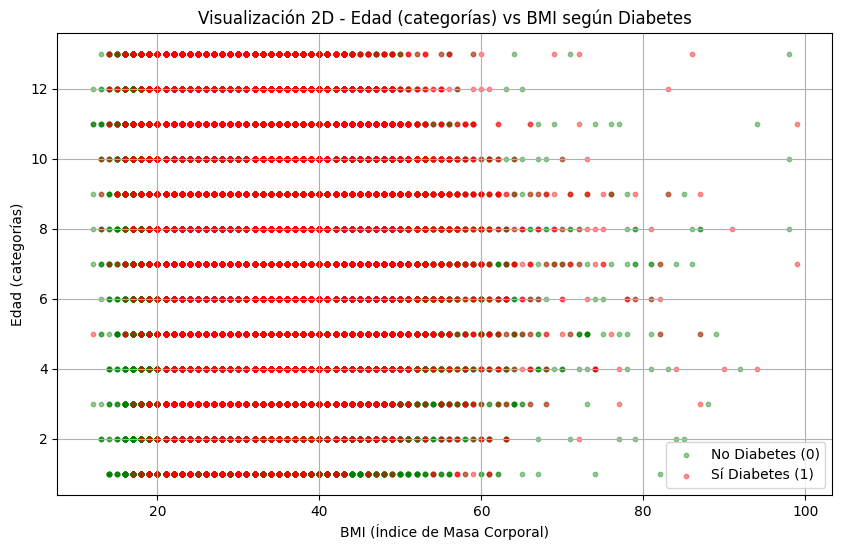

In [236]:
plt.figure(figsize=(10,6))
plt.scatter(data[data["Diabetes_binary"]==0]["BMI"], data[data["Diabetes_binary"]==0]["Age"],
            alpha=0.4, c="green", label="No Diabetes (0)", s=10)
plt.scatter(data[data["Diabetes_binary"]==1]["BMI"], data[data["Diabetes_binary"]==1]["Age"],
            alpha=0.4, c="red", label="Sí Diabetes (1)", s=10)

plt.xlabel("BMI (Índice de Masa Corporal)")
plt.ylabel("Edad (categorías)")
plt.title("Visualización 2D - Edad (categorías) vs BMI según Diabetes")
plt.legend()
plt.grid(True)
plt.show()



# **Separar X/y + Train/Test (80/20, estratificado)**

In [237]:
X = data.drop(["Diabetes_012", "Diabetes_binary"], axis=1).values
y = data["Diabetes_binary"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((178840, 21), (44710, 21))

In [238]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Agregar columna de 1s para bias
X_train_s = np.concatenate([np.ones((X_train_s.shape[0], 1)), X_train_s], axis=1)
X_test_s  = np.concatenate([np.ones((X_test_s.shape[0], 1)),  X_test_s], axis=1)


# **Implementación del modelo (sigmoide, costo, gradiente)**

Costo final: 0.39641179078675964


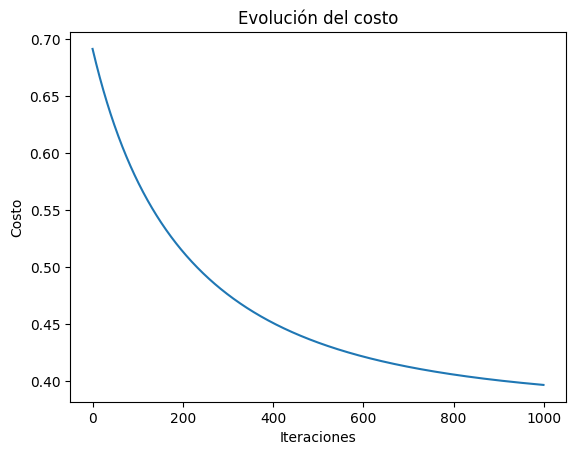

In [239]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    eps = 1e-8
    return -(1/m) * np.sum(y*np.log(h+eps) + (1-y)*np.log(1-h+eps))

def gradient_descent(X, y, theta, alpha=0.01, iters=1000):
    m = len(y)
    J_hist = []
    for _ in range(iters):
        h = sigmoid(X @ theta)
        grad = (1/m) * (X.T @ (h - y))
        theta -= alpha * grad
        J_hist.append(compute_cost(X, y, theta))
    return theta, J_hist

# Entrenar
theta0 = np.zeros((X_train_s.shape[1], 1))
theta, J = gradient_descent(X_train_s, y_train, theta0, alpha=0.01, iters=1000)

print("Costo final:", J[-1])
plt.plot(J); plt.xlabel("Iteraciones"); plt.ylabel("Costo"); plt.title("Evolución del costo"); plt.show()



# **Predicciones + Probabilidades + Tabla**

In [240]:
# Probabilidades y predicciones
probs_test = sigmoid(X_test_s @ theta).ravel()
y_pred = (probs_test >= 0.5).astype(int)
y_true = y_test.ravel()

# Tabla tipo “presentación”
X_test_original = scaler.inverse_transform(X_test_s[:,1:])  # quitar la col de 1s
cols_features = data.drop(["Diabetes_012", "Diabetes_binary"], axis=1).columns
df_features = pd.DataFrame(X_test_original, columns=cols_features)

df_pred = pd.DataFrame({
    "Valores reales (Y)": y_true,
    "Predicción (0/1)": y_pred,
    "Probabilidad de diabetes %": np.round(probs_test*100, 2),
})
df_final = pd.concat([df_pred, df_features], axis=1)

df_final.head(20)


,Valores reales (Y),Predicción (0/1),Probabilidad de diabetes %,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,6.13,0.0,0.0,1.0,32.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,10.0
1,0,0,17.08,0.0,1.0,1.0,27.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,30.0,0.0,0.0,0.0,11.0,5.0,6.0
2,0,0,20.31,1.0,1.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0,6.0,9.0
3,0,0,17.18,1.0,0.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,6.0,10.0
4,0,0,12.56,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,3.0,6.0,7.0
5,1,0,18.81,0.0,0.0,1.0,25.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,13.0,6.0,7.0
6,0,0,21.95,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,6.0,0.0,0.0,11.0,6.0,8.0
7,0,0,25.89,1.0,1.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,4.0,0.0,1.0,8.0,6.0,11.0
8,0,0,17.35,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,9.0,5.0,8.0
9,0,0,31.84,1.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,6.0,8.0


# **Métricas (accuracy, matriz, reporte, ROC-AUC)**

Accuracy (sklearn): 0.8326   |   Accuracy (manual): 0.8326
Matriz de confusión:
 [[35760  1148]
 [ 6336  1466]]


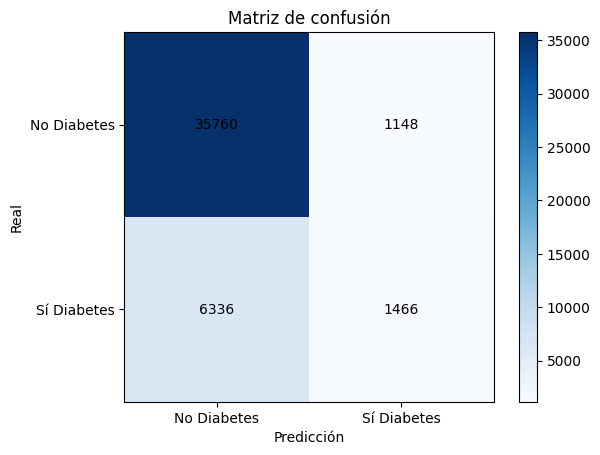

              precision    recall  f1-score   support

 No Diabetes       0.85      0.97      0.91     36908
 Sí Diabetes       0.56      0.19      0.28      7802

    accuracy                           0.83     44710
   macro avg       0.71      0.58      0.59     44710
weighted avg       0.80      0.83      0.80     44710

ROC-AUC: 0.7963


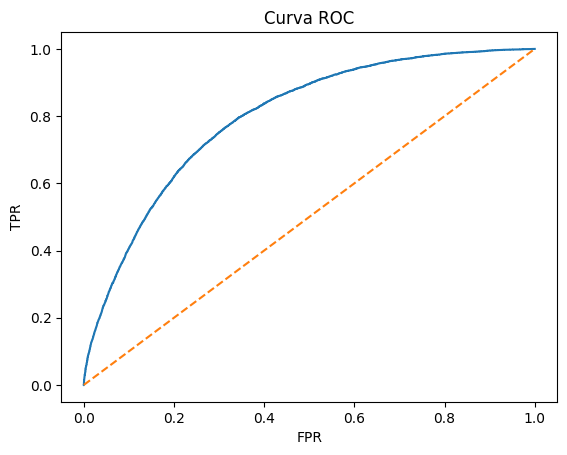

In [241]:
# Accuracy (sklearn y manual)
acc1 = accuracy_score(y_true, y_pred)
acc2 = np.mean(y_pred == y_true)
print(f"Accuracy (sklearn): {acc1:.4f}   |   Accuracy (manual): {acc2:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusión:\n", cm)

# Gráfico simple de matriz (sin seaborn)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["No Diabetes","Sí Diabetes"]); ax.set_yticklabels(["No Diabetes","Sí Diabetes"])
ax.set_xlabel("Predicción"); ax.set_ylabel("Real"); ax.set_title("Matriz de confusión")
plt.colorbar(im); plt.show()

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=["No Diabetes","Sí Diabetes"]))

# ROC-AUC (opcional, muy presentable)
auc = roc_auc_score(y_true, probs_test)
fpr, tpr, _ = roc_curve(y_true, probs_test)
print(f"ROC-AUC: {auc:.4f}")
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC"); plt.show()


# **Presición del modelo de regresión logística**

In [247]:
from sklearn.metrics import accuracy_score
precision_sklearn = accuracy_score(y_test, y_pred) * 100
print(f"Precisión del modelo: {precision_sklearn:.2f}%")


Precisión del modelo: 83.26%


## **Conclusión**

#La precisión del modelo de regresión logística indica que alrededor de 83 de cada 100 predicciones fueron correctas.
# Este resultado muestra que el modelo logra un buen desempeño para identificar correctamente casos de diabetes.